## Playground

In [25]:
!gpustat

n104.mcl.weizmann.ac.il  Thu Jun 16 09:48:44 2022  450.80.02
[0] GeForce RTX 2080 Ti | 25'C,   0 % |     0 / 11019 MB |
[1] GeForce RTX 2080 Ti | 25'C,   0 % |  1638 / 11019 MB | yanivni(1635M)
[2] GeForce RTX 2080 Ti | 26'C,   0 % |     0 / 11019 MB |
[3] GeForce RTX 2080 Ti | 25'C,   0 % |     0 / 11019 MB |
[4] GeForce RTX 2080 Ti | 24'C,   0 % |     0 / 11019 MB |
[5] GeForce RTX 2080 Ti | 23'C,   0 % |     0 / 11019 MB |
[6] GeForce RTX 2080 Ti | 24'C,   0 % |     0 / 11019 MB |
[7] GeForce RTX 2080 Ti | 24'C,   0 % |     0 / 11019 MB |


In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from common_utils.notebook_utils import *

In [34]:
from torch.utils.data import DataLoader
from PIL import Image
import pytorch_lightning as pl

from common_utils.resize_right import resize
from datasets.cropset import CropSet
from diffusion.diffusion import Diffusion
from diffusion.sr_diffusion import SRDiffusion
from diffusion.diffusion_pyramid import DiffusionPyramid
from diffusion.diffusion_pyramid_sr import SRDiffusionPyramid
from diffusion.diffusion_utils import save_diffusion_sample
from models.zssr import ZSSRNet
from models.unet import Unet
from models.nextnet import NextNet
from models.modules import *

In [5]:
def show_sample(sample):
    s = (sample.clamp(-1, 1) + 1) / 2
    s = (s * 255).type(torch.uint8).moveaxis(1, 3)
    s = s.cpu().numpy()
    
    grid_size = int(len(s) ** 0.5)
    if grid_size > 1:
        f, axarr = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size))
        for idx, img in enumerate(s):
            axarr[idx // grid_size, idx % grid_size].imshow(img)
    else:
        plt.imshow(s[0])
        
    plt.show()

## Load pyramid from checkpoints

In [10]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/38_sr3_1k_noising_10k_training_4_levels_0.135_coarsest/checkpoints'
diffusion_timesteps = 2000
image_name = 'balloons.png'
levels = 3
coarsest_size_ratio = 0.135
size_ratios = coarsest_size_ratio ** (1.0 / (levels - 1))

pyramid = GaussianSRDiffusionPyramid.load_from_checkpoint(path_to_checkpoints, 
                                                          f'./images/{image_name}', 
                                                          levels, 
                                                          size_ratios,
                                                          diffusion_timesteps)

In [ ]:
pyramid.sample()

## Experiment: Re-using SR resolution layer

In [6]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/38_sr3_1k_noising_10k_training_4_levels_0.135_coarsest/checkpoints'
image_name = 'balloons.png'
levels = 4
coarsest_size_ratio = 0.135
size_ratios = coarsest_size_ratio ** (1.0 / (levels - 1))

In [18]:
level0 = Diffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=99999.ckpt'), 
                                                model=ZSSRNet(), timesteps=1000).to(device='cuda:0')
level1 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=1-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')
level2 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=2-step=99999.ckpt'), 
                                                model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')
level3 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=3-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')

### Attempt: Sample using corresponding resolution layers

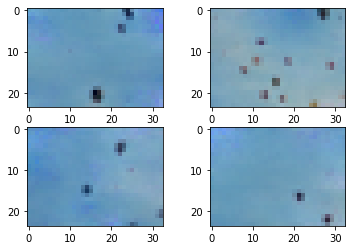

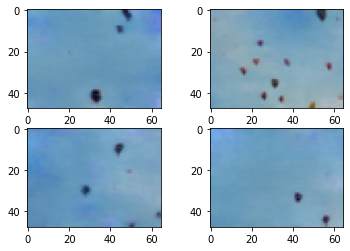

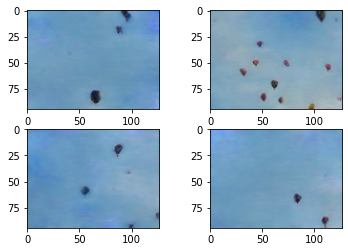

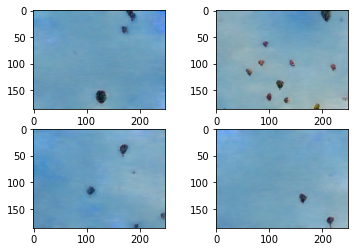

In [14]:
sizes = [(24, 33), (48, 65), (95, 127), (186, 248)]

s0 = level0.sample(image_size=sizes[0], batch_size=4)
s0_r = resize(s0, out_shape=sizes[1])

s1 = level1.sample(s0_r, image_size=sizes[1])
s1_r = resize(s1, out_shape=sizes[2])

s2 = level2.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level3.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

### Attempt: Sample using layer0 and layer1

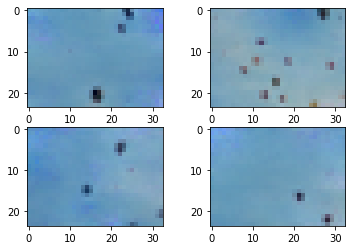

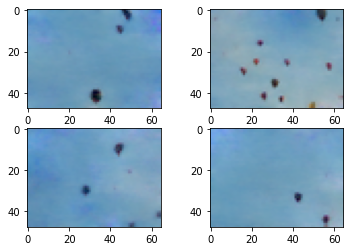

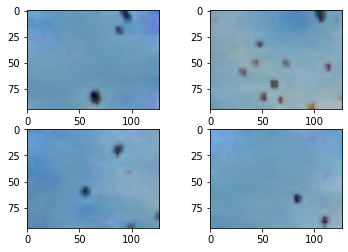

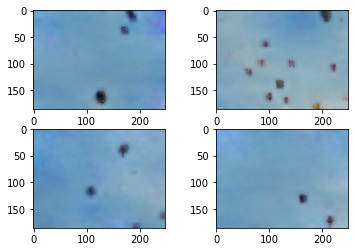

In [15]:
# Same s0 and s0_r

s1 = level1.sample(s0_r, image_size=sizes[1])
s1_r = resize(s0, out_shape=sizes[2])

s2 = level1.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level1.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

### Attempt: Sample using layer0 and layer2

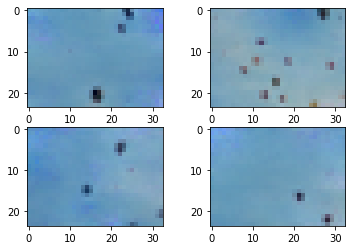

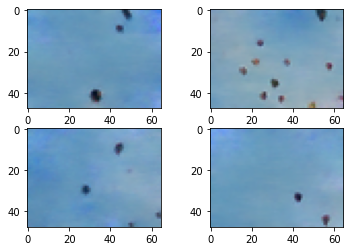

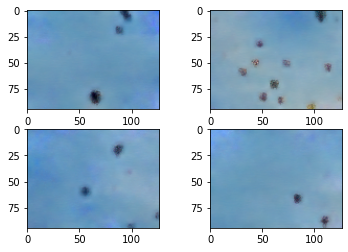

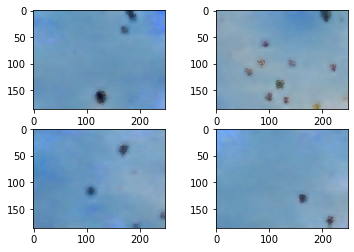

In [16]:
# Same s0 and s0_r

s1 = level2.sample(s0_r, image_size=sizes[1])
s1_r = resize(s0, out_shape=sizes[2])

s2 = level2.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level2.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

## Experiment: Improving sampling using back-projection

In [19]:
def back_projection(y_sr, y_lr):
    y_sr += resize(y_lr - resize(y_sr, scale_factors=size_ratios, out_shape=y_lr.shape), scale_factors=1/size_ratios, out_shape=y_sr.shape)
    return y_sr.clip(0, 1)

### Attempt: Use backprojection for sampling improval

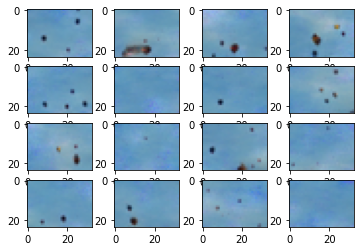

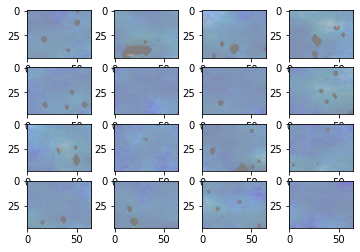

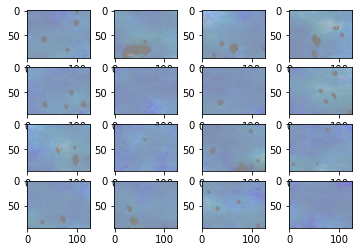

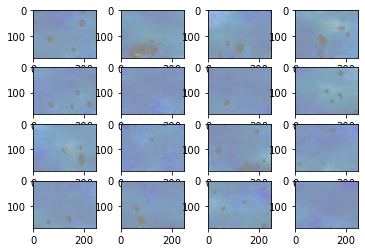

In [49]:
sizes = [(24, 33), (48, 65), (95, 127), (186, 248)]

s0 = level0.sample(image_size=sizes[0], batch_size=16)
s0_r = resize(s0, out_shape=sizes[1])
s1 = level1.sample(s0_r, image_size=sizes[1])
s1 = back_projection(s1, s0)

s1_r = resize(s1, out_shape=sizes[2])
s2 = level2.sample(s1_r, image_size=sizes[2])
s2 = back_projection(s2, s1)

s2_r = resize(s2, out_shape=sizes[3])
s3 = level3.sample(s2_r, image_size=sizes[3])
s3 = back_projection(s3, s2)

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

### Attempt: Don't use backprojection

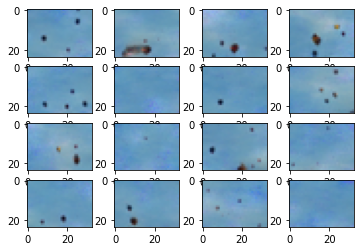

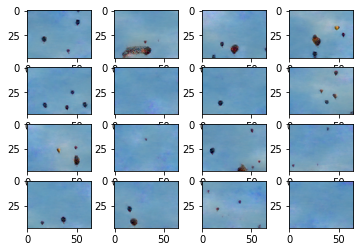

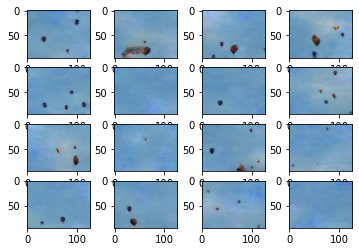

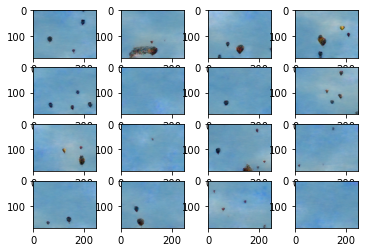

In [50]:
s0_r = resize(s0, out_shape=sizes[1])
s1 = level1.sample(s0_r, image_size=sizes[1])

s1_r = resize(s1, out_shape=sizes[2])
s2 = level2.sample(s1_r, image_size=sizes[2])

s2_r = resize(s2, out_shape=sizes[3])
s3 = level3.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

## Debugging- Laplacian pyramid

The following 2 cells contain code from IntroToCV-ex2 which generated laplacian pyramids. I used it because there were some issues with my original laplacian but it's irrelevant and unused now.

In [69]:
from collections import namedtuple
import os
import skimage.color
from PIL import Image
from IPython.display import display, Markdown
import numpy as np
from scipy.ndimage import convolve
import ipywidgets as widgets

def imread(path):
    image = Image.open(path).convert(mode='RGB')
    image = np.array(image).astype(np.float32) / 255
    return image


def _imwrite(path, image):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    Image.fromarray(image).save(path)


def _imshow(image, title=None):
    if title:
        display(Markdown("### %s" % title))
    display(Image.fromarray(image))

def rgb2grey(images):
    return skimage.color.rgb2grey(images)

def safe_normalize(image, bounds=(0, 1)):
    """Receive an `image` represented by float numbers, with given range `bounds`, and convert it to `uint8`

    Args:
        image (np.ndarray): the image
        bounds (Tuple[float, float]): tuple of `(minval, maxval)`,  minimum and maximum values of image
    
    Returns:
        np.ndarray: the normalized image, with `dtype=np.uint8`

    """
    bounded_image = image.clip(bounds[0], bounds[1])
    return (((bounded_image - bounds[0]) / (bounds[1]-bounds[0]) * 255).astype(np.uint8))            

### PROVIDED FUNCTION
def imwrite(path, image, bounds=(0, 1), **kwargs):
    """Normalize `image` and save it to `path`"""
    image = safe_normalize(image, bounds)
    return _imwrite(path, image, **kwargs)


### PROVIDED FUNCTION
def imshow(image, bounds=(0, 1), **kwargs):
    """Normalize `image` and show it."""
    image = safe_normalize(image, bounds)
    return _imshow(image, **kwargs)


### PROVIDED FUNCTION
def imshow_tabs(images, tab_names, titles=None, kwargs=None):
    """Normalize `images`, and show them in tabs with the given tab names"""
    assert len(images) == len(tab_names)
    if not isinstance(titles, (list, tuple)):
        titles = [titles] * len(images)
    assert len(images) == len(titles)
    if kwargs is None:
        kwargs = {}
    n = len(images)
    if isinstance(kwargs, dict):
        kwargs = [kwargs for _ in range(n)]
    outputs = [widgets.Output() for _ in range(n)]
    boxes = widgets.Tab(children=outputs)
    for i, (output, image, tab_name, title, kw) in enumerate(zip(outputs, images, tab_names, titles, kwargs)):
        boxes.set_title(i, tab_name)
        with output:
            imshow(image, title=title, **kw)
    
    display(boxes)    

### PROVIDED FUNCTION
def imshow_hbox(images, titles=None, kwargs=None):
    """Normalize `images`, and show them side-by-side"""
    if kwargs is None:
        kwargs = {}
    if not isinstance(titles, (list, tuple)):
        titles = [titles] * len(images)
    assert len(images) == len(titles)

    n = len(images)
    if isinstance(kwargs, dict):
        kwargs = [kwargs for _ in range(n)]
    outputs = [widgets.Output() for _ in range(n)]
    boxes = widgets.HBox(children=outputs)
    for i, (output, image, title, kw) in enumerate(zip(outputs, images, titles, kwargs)):
        with output:
            imshow(image, title=title, **kw)
    
    display(boxes)
    
### PROVIDED FUNCTION
def imshow_vbox(images, titles=None, kwargs=None):
    """Normalize `images`, and show them side-by-side"""
    if kwargs is None:
        kwargs = {}
    if not isinstance(titles, (list, tuple)):
        titles = [titles] * len(images)
    assert len(images) == len(titles)

    n = len(images)
    if isinstance(kwargs, dict):
        kwargs = [kwargs for _ in range(n)]
    outputs = [widgets.Output() for _ in range(n)]
    boxes = widgets.VBox(children=outputs)
    for i, (output, image, title, kw) in enumerate(zip(outputs, images, titles, kwargs)):
        with output:
            imshow(image, title=title, **kw)
    
    display(boxes)
    

def pyramid_kernel(a):
    """Return the 5-by-5 generating kernel, given parameter `a`
    
    Args:
        a (float): the kernel parameter
    
    Returns:
        np.ndarray: 5-by-5 generating kernel
    """
    one_dim_kernel = np.array([0.25 - a / 2, 0.25, a, 0.25, 0.25 - a / 2])
    return one_dim_kernel[:, None] * one_dim_kernel

### PROVIDED FUNCTION
def conv2d(image, kernel):
    """Convolve image with 2D kernel
    
    Args:
        image (np.ndarray): base image
        kernel (np.ndarray): kernel to convolve with `image`
    
    Returns:
        np.ndarray: `image` convolved with `kernel`
    """

    if image.ndim == 3 and kernel.ndim == 2:
        kernel = np.expand_dims(kernel, -1)
    
    return convolve(image, kernel, mode='mirror')

def pyramid_reduce(image, kernel):
    """Reduce an image given a kernel
    
    See:
        "The Laplacian Pyramid as a Compact Image Code" by Burt & Adelson (1983)
    
    Args:
        image (np.ndarray): image to reduce, of size (2*h, 2*w)
        kernel (np.ndarray): kernel to use for the reduction (usually 5x5)
    
    Returns:
        np.ndarray: reduced image, of size (h, w)
    """
    # Pyramid reduce is comprised of convolving each pixel's surrondings with the kernel
    # and subsampling only even pixels.
    # return conv2d(image, kernel)[::2,::2]

### PROVIDED FUNCTION
def pyramid_expand(image, kernel, out_size=None):
    """Expand an image given a kernel
        
    Args:
        image (np.ndarray): image to expand, of size (h, w)
        kernel (np.ndarray): kernel to use for the expansion (usually 5x5)
        out_size (Tuple[int, int], optional): the expected shape of the returned image
        
    Returns:
        np.ndarray: expanded image, of size (2*h, 2*w)
    """
    h, w, *c = image.shape
    outh, outw = (2 * h, 2 * w) if out_size is None else out_size
    assert abs(outh - 2 * h) <= 1 and abs(outw - 2 * w) <= 1, "`out_size` should be close to `(2*h, 2*w)`"
    new_image = np.zeros((outh, outw, *c))    
    new_image[::2, ::2, ...] = image
    return conv2d(new_image, 4 * kernel)

def gaussian_reduce(image, coarsest_ratio, levels):
    level_ratio = coarsest_ratio ** (1.0 / (levels - 1))
    gaussian_pyramid = [image]
    for i in range(levels):
        gaussian_pyramid.append(resize(gaussian_pyramid[-1], scale_factors=level_ratio))#pyramid_reduce(gaussian_pyramid[-1], kernel))
    return gaussian_pyramid

def laplacian_reduce(image, coarsest_ratio, levels):
    level_ratio = coarsest_ratio ** (1.0 / (levels - 1))
    gaussian_pyramid = gaussian_reduce(image, coarsest_ratio, levels)[:-1]
    prev_level = gaussian_pyramid.pop()
    laplacian_pyramid = [prev_level]
    while gaussian_pyramid:
        current_level = gaussian_pyramid.pop()
        size = (current_level.shape[1], current_level.shape[2])
        laplacian_pyramid.insert(0, current_level - resize(prev_level, scale_factors=1/level_ratio, out_shape=size))#pyramid_expand(prev_level, kernel, size))
        prev_level = current_level
    return laplacian_pyramid

In [23]:
img = torch.tensor(imread(f'./images/{image_name}')).moveaxis(2, 0)
laplace = laplacian_reduce(img, coarsest_size_ratio, levels)[::-1]
titles = ['Level %d' % i for i in range(len(laplace))]
kwargs = ([{'bounds': (0, 1)}] + [{'bounds': (-1, 1)} for _ in range(len(laplace) - 1)])        


# TODO CHANGE
print([l.shape for l in laplace])
laplace_for_show = [l.moveaxis(0, 2).numpy() for l in laplace]
imshow_vbox(laplace_for_show, kwargs=kwargs)
torchvision.utils.save_image(laplace[2], '/home/yanivni/data/tmp/laptest.png')

[torch.Size([3, 26, 34]), torch.Size([3, 50, 66]), torch.Size([3, 96, 128]), torch.Size([3, 186, 248])]


The following cells generates a laplace pyramid in a simple manner. Then it is validated against the above laplace pyramid, and we can see that the printed distance norm between them is extremely small.

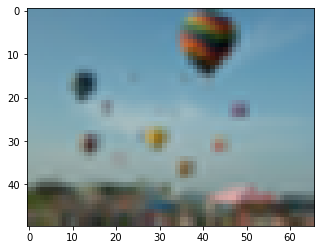

NameError: name 'laplace' is not defined

In [7]:
orig_image = torchvision.transforms.ToTensor()(Image.open(f'./images/{image_name}'))
img_pyramid = [orig_image]
for i in range(levels - 1):
    img_pyramid.insert(0, resize(img_pyramid[0], scale_factors=size_ratios))

laplace2 = [img_pyramid[0]]
for level in range(1, levels):
    l = img_pyramid[level] - resize(img_pyramid[level - 1], scale_factors=1 / size_ratios, out_shape=img_pyramid[level].shape)
    laplace2.append(l)
    

img0_r = resize(img_pyramid[0], scale_factors=1/size_ratios, out_shape=img_pyramid[1].shape)
plt.imshow(img0_r.moveaxis(0, 2)); plt.show()
gt = img0_r + laplace[1]
plt.imshow(gt.moveaxis(0, 2)); plt.show()
plt.imshow(img_pyramid[1].moveaxis(0, 2)); plt.show()

print([torch.sum(laplace[i] - laplace2[i]) for i in range(len(laplace))])
print([(laplace[i].mean(), laplace2[i].mean()) for i in range(len(laplace))])

The following cells are an attempt to use a trained model to predict the laplace of a crop. The model (39) was buggy since the laplace hr_crop was normalized twice to (-1, 1).

In [27]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/39_laplace_attempt_1k_noising_10k_training_5_levels_0.135_coarsest/checkpoints'

path_to_sr_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/37_full_sr3_2k_noising_100k_training_5_levels_0.25_coarsest/checkpoints'
image_name = 'balloons.png'
#levels = 5
#coarsest_size_ratio = 0.135
#size_ratios = coarsest_size_ratio ** (1.0 / (levels - 1))

level1 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=1-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')

level1_normal_sr = SRDiffusion.load_from_checkpoint(os.path.join(path_to_sr_checkpoints, 'level=1-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=2000).to(device='cuda:0')

level1_size = laplace2[1].shape[1:]
s0 = (img_pyramid[0].unsqueeze(0).to(device='cuda:0') * 2) - 1
s0_r = resize(s0, out_shape=level1_size)
s1_l = level1.sample(s0_r, image_size=level1_size)

s1_l_gt = laplace[1].to(device='cuda:0')

s1 = s1_l + s0_r
s1_gt = s1_l_gt + s0_r
s1_sr = level1_normal_sr.sample(s0_r, image_size=level1_size)

In [ ]:
show_sample(s0)
show_sample(s1_l)
show_sample(s1_l_gt.unsqueeze(0))
show_sample(s1)
show_sample(s1_gt)
show_sample(s1_sr)
print(s1_l.mean(), s1_l_gt.mean())

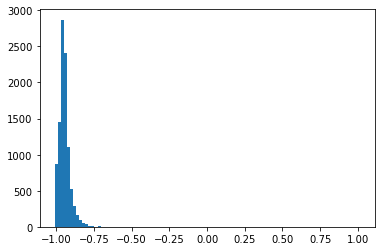

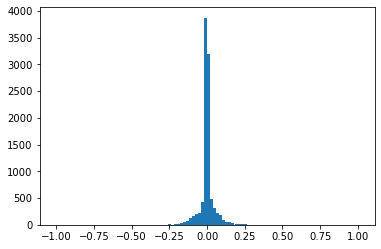

In [29]:
def draw_laplace_hist(l):
    bins = 100
    h = torch.histc(l.cpu(), bins=bins, min=-1, max=1)
    plt.bar(np.linspace(-1, 1, bins), h, width=0.02)
    plt.show()

draw_laplace_hist(s1_l)
draw_laplace_hist(s1_l_gt)

The following cells are the result of a training after fixing the above-mentioned bug. Is can be seen that now the model predicts the laplacian with great precision.

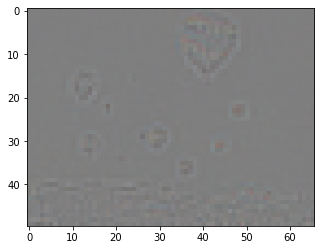

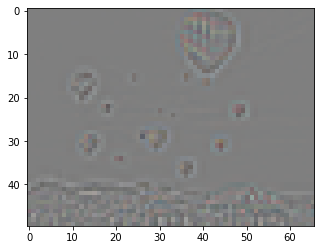

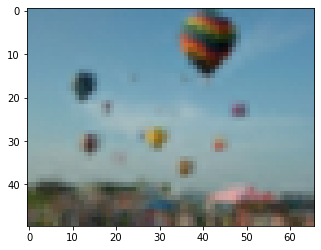

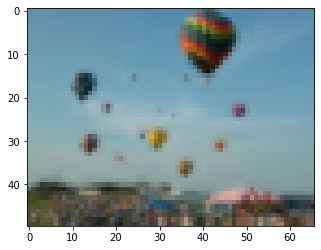

In [43]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/version_9/checkpoints'
image_name = 'balloons.png'

level1 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=1-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=500).to(device='cuda:0')

level1_size = laplace2[1].shape[1:]
s0 = (img_pyramid[0].unsqueeze(0).to(device='cuda:0') * 2) - 1
s0_r = resize(s0, out_shape=level1_size)
s1_l = level1.sample(s0_r, image_size=level1_size)
s1_l_gt = laplace[1].to(device='cuda:0')
s1 = s1_l + s0_r
s1_gt = s1_l_gt + s0_r

show_sample(s1_l)
show_sample(s1_l_gt.unsqueeze(0))
show_sample(s1)
show_sample(s1_gt)

The above prediction works great. We can also try to see how it works on crops from the image, and then how it works on generated images from level0 of the pyramid.

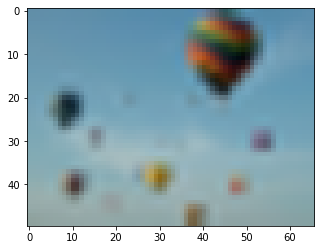

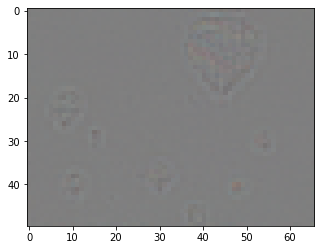

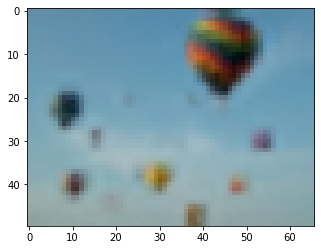

In [44]:
crop_size = (int(s0.shape[-2] * 0.8), int(s0.shape[-1] * 0.8))
s0_crop = torchvision.transforms.RandomCrop(crop_size, pad_if_needed=True, padding_mode='reflect')(s0)
s0_crop_r = resize(s0_crop, out_shape=level1_size)
s1_crop_l = level1.sample(s0_crop_r, image_size=level1_size)
s1_crop = s1_crop_l + s0_crop_r
show_sample(s0_crop_r)
show_sample(s1_crop_l)
show_sample(s1_crop)

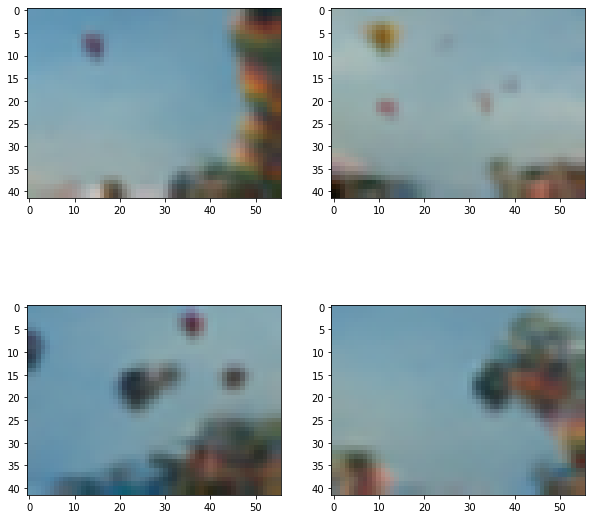

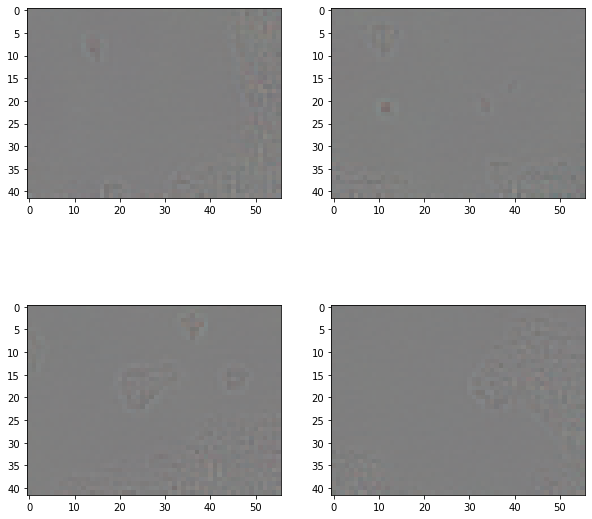

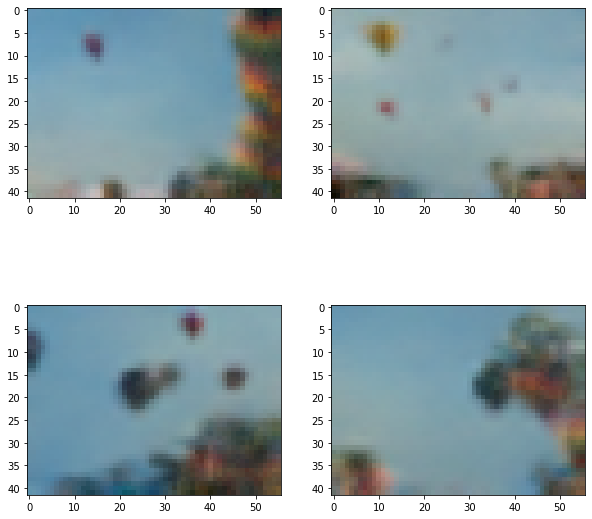

In [339]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/37_full_sr3_2k_noising_100k_training_5_levels/checkpoints'

level0 = GaussianDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=99999.ckpt'), 
                                          model=ZSSRNet(), timesteps=2000).to(device='cuda:0')

s0 = level0.sample(image_size=crop_size, batch_size=4)
s0_r = resize(s0, out_shape=level1_size)
s1_l = level1.sample(s0_r, image_size=level1_size)
s1 = s1_l + s0_r
show_sample(s0_r)
show_sample(s1_l)
show_sample(s1)

## Debugging - Attempt to improve level0

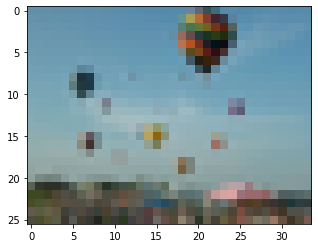

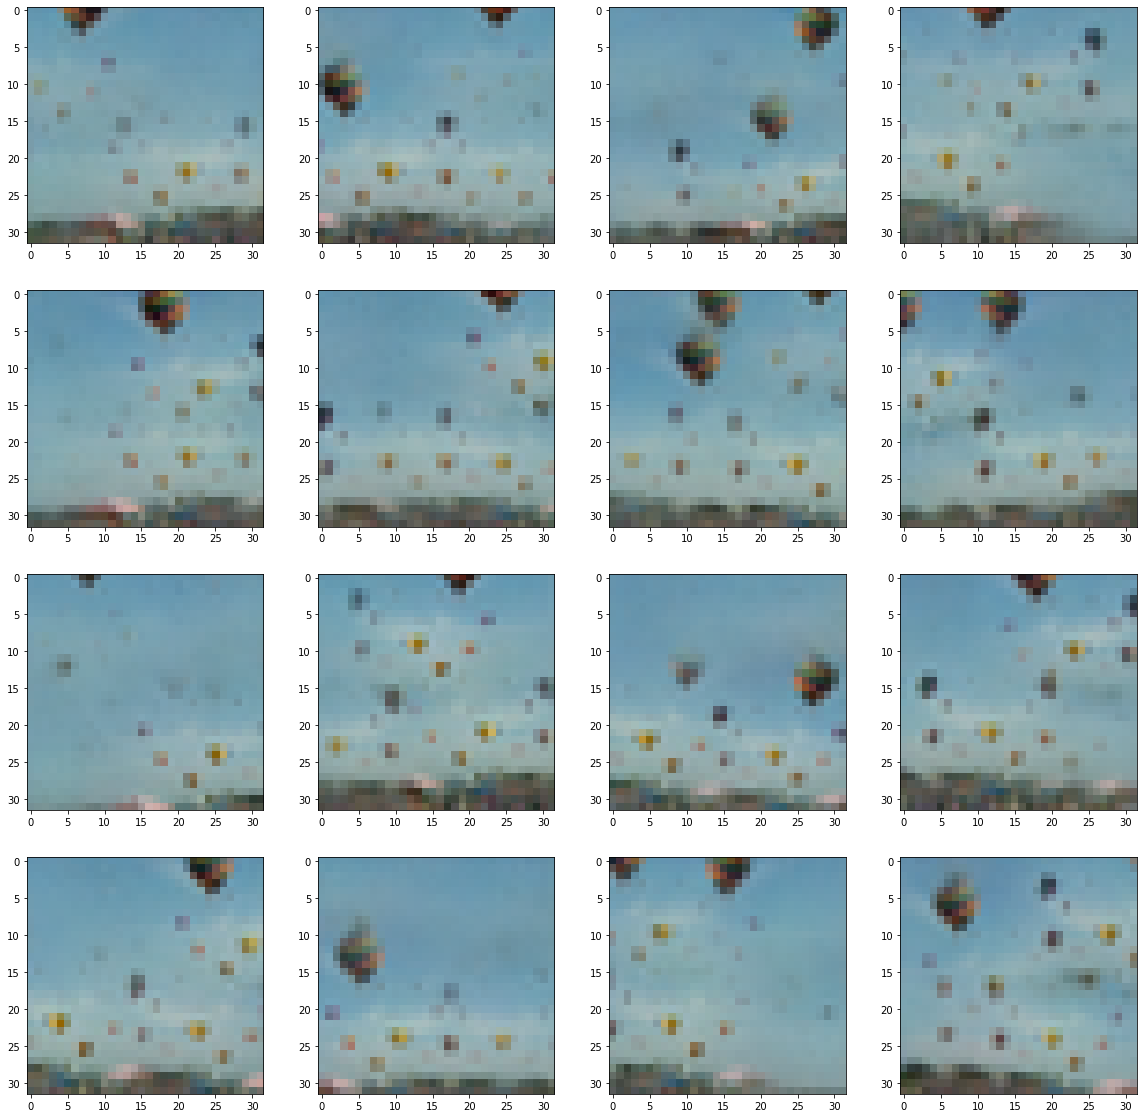

In [35]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/version_3/checkpoints'


#level0 = Diffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=34999.ckpt'), 
#                                          model=ZSSRNet(filters_per_layer=128), timesteps=500).to(device='cuda:0')
#level0 = Diffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=34999.ckpt'), 
#                                          model=Unet(dim=32, dim_mults=(1,2)), timesteps=500).to(device='cuda:0')
level0 = Diffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=34999.ckpt'), 
                                          model=NextNet(), timesteps=500).to(device='cuda:0')
                                        
s0 = level0.sample((32, 32), batch_size=16)
#s0 = level0.sample((150, 150), batch_size=1)
#s0 = level0.sample((24, 33), batch_size=16)
show_sample((img_pyramid[0].unsqueeze(0) * 2) - 1)
#show_sample(level0.sample((24, 33), batch_size=1))
show_sample(s0)

In [ ]:
print(s0.shape)
out_shape = (s0.shape[-2] * 2, s0.shape[-1] * 2)
s0_r = resize(s0, out_shape=out_shape)
s1_l = level1.sample(s0_r, image_size=out_shape)
s1 = s1_l + s0_r

#show_sample(s1_l)
show_sample(s1)